In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

<h2>Process the images and resize them to the preferred size </h2>

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

<h2>Preparing the training and testing data</h2>

In [4]:
train = get_training_data('D:/Downloads/chest_xray/train')
test = get_training_data('D:/Downloads/chest_xray/test')
val = get_training_data('D:/Downloads/chest_xray/val')

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



D:\TEMP\ipykernel_7936\4037217275.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [5]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3883
Normal: 1349
Pneumonia - Normal: 2534


<h2>Visualize training images</h2>

PNEUMONIA


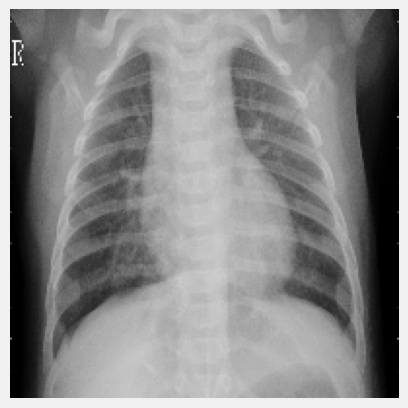

In [6]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

<h2 >We are incoprating the validation data into the training data because it does not contain enough examples. </h2>

In [7]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [8]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

Data augmentation 

In [9]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

**CNN (Convolutional Neural Network)**

In [10]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 256)     2560      
                                                                 
 activation (Activation)     (None, 200, 200, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 256)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 256)    400       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      147520    
                                                                 
 activation_1 (Activation)   (None, 100, 100, 64)      0

In [12]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
415/415 [==============================] - 1132s 3s/step - loss: 0.5963 - acc: 0.7044 - val_loss: 0.8869 - val_acc: 0.7213
Epoch 2/15
415/415 [==============================] - 1107s 3s/step - loss: 0.4748 - acc: 0.7577 - val_loss: 0.4532 - val_acc: 0.7300
Epoch 3/15
415/415 [==============================] - 1106s 3s/step - loss: 0.4158 - acc: 0.8032 - val_loss: 0.4182 - val_acc: 0.7473
Epoch 4/15
415/415 [==============================] - 1109s 3s/step - loss: 0.3782 - acc: 0.8194 - val_loss: 0.3099 - val_acc: 0.8621
Epoch 5/15
415/415 [==============================] - 1103s 3s/step - loss: 0.3436 - acc: 0.8433 - val_loss: 0.2513 - val_acc: 0.9103
Epoch 6/15
415/415 [==============================] - 1106s 3s/step - loss: 0.3350 - acc: 0.8548 - val_loss: 0.2805 - val_acc: 0.8775
Epoch 7/15
415/415 [==============================] - 1105s 3s/step - loss: 0.3172 - acc: 0.8662 - val_loss: 0.2126 - val_acc: 0.9219
Epoch 8/15
415/415 [==============================] - 1103s 3s

In [13]:
model.evaluate(X_test, y_test)

41/41 [==============================] - 55s 1s/step - loss: 0.2173 - acc: 0.9120


[0.2172916978597641, 0.9120370149612427]

**Visualizing our training progress**

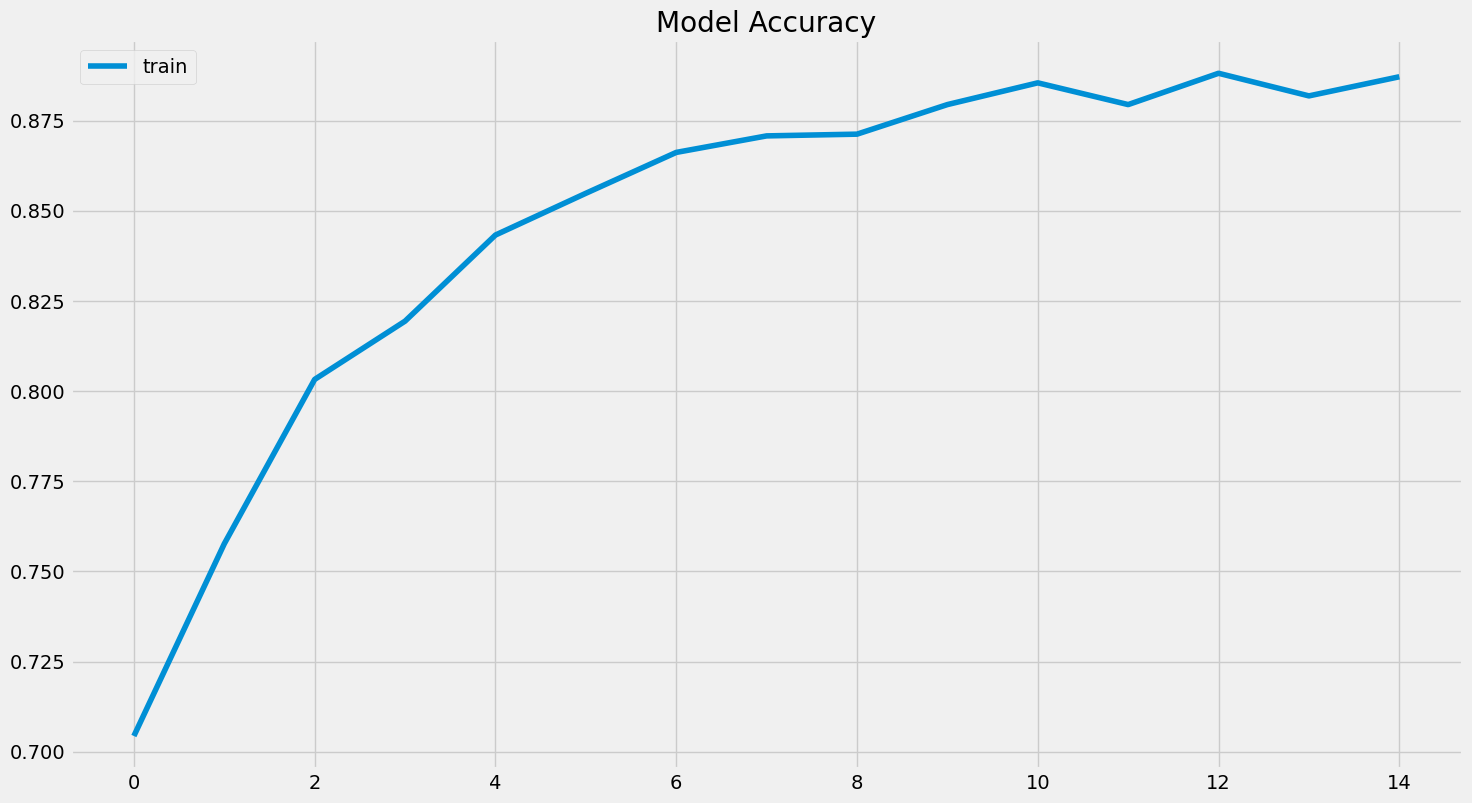

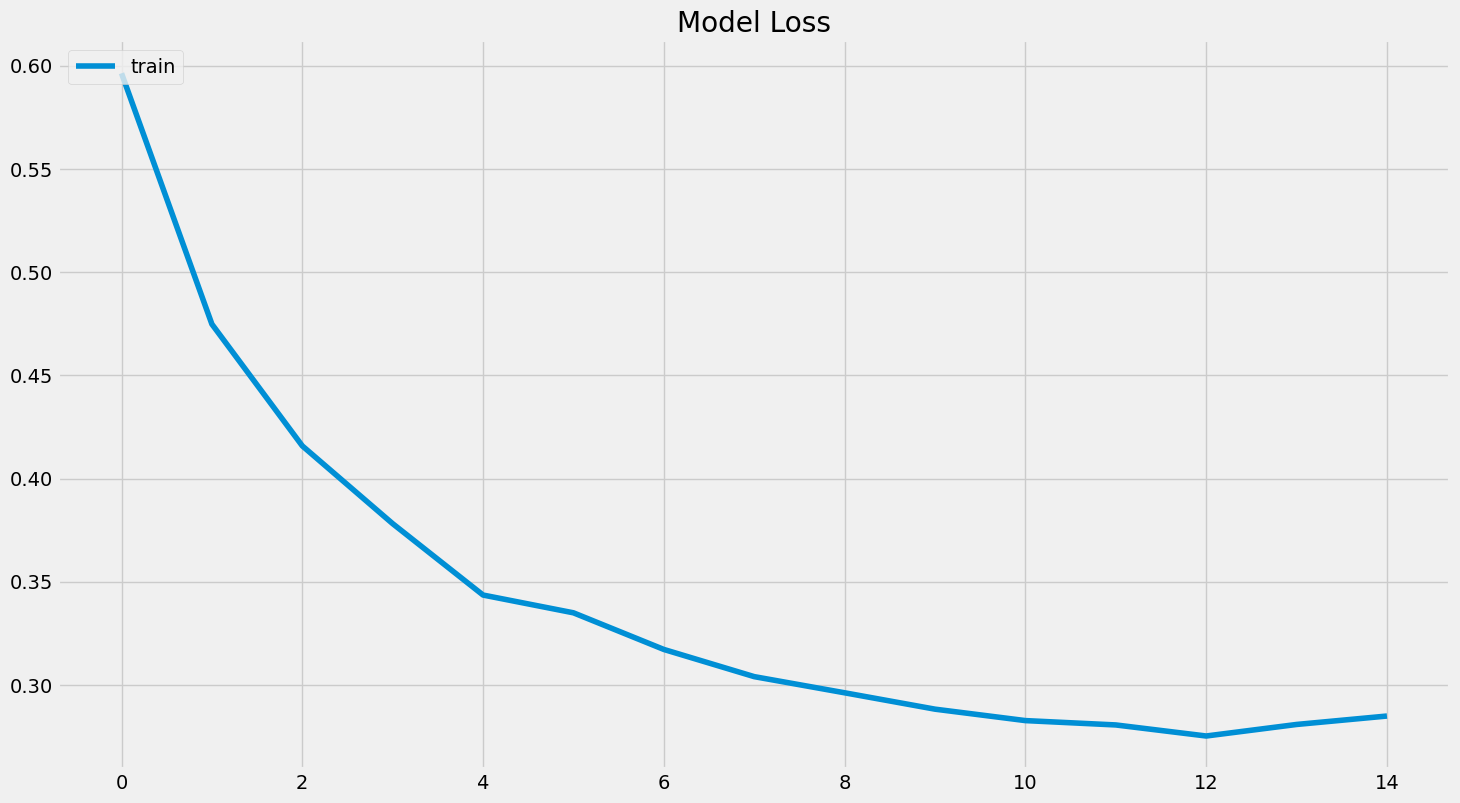

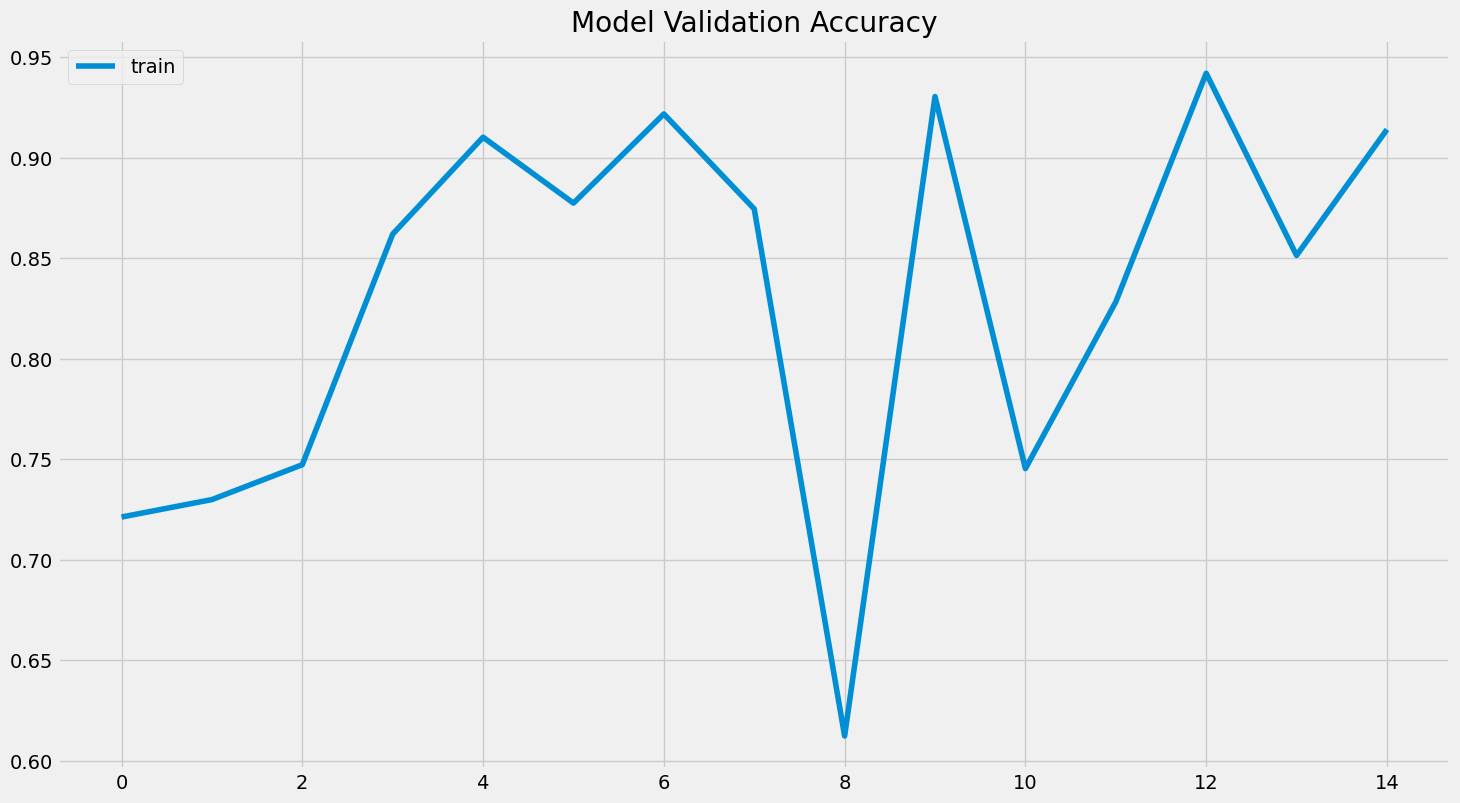

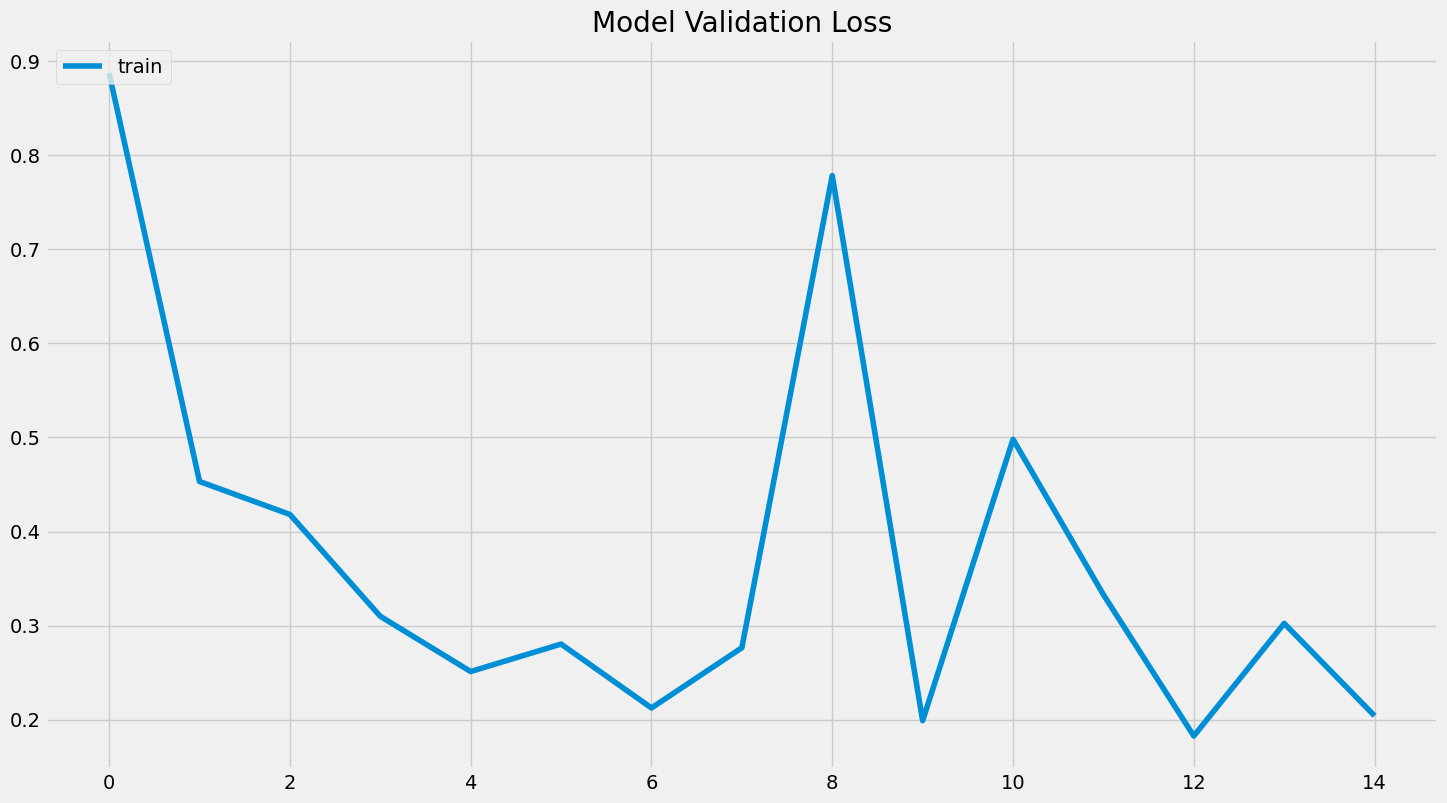

In [14]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

**Prepare data for precision vs. recall and ROC**

In [15]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

130/130 [==============================] - 249s 2s/step


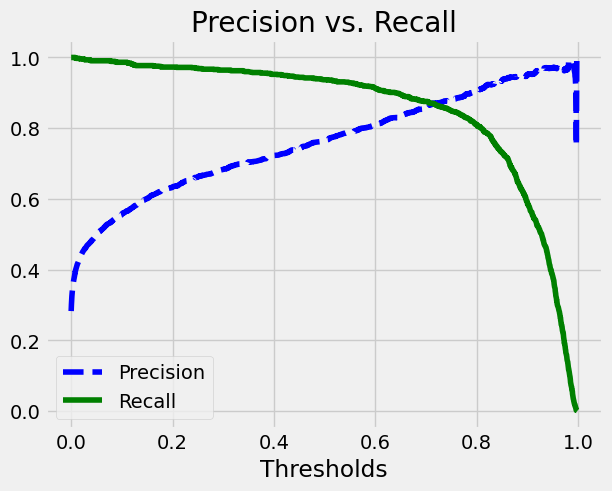

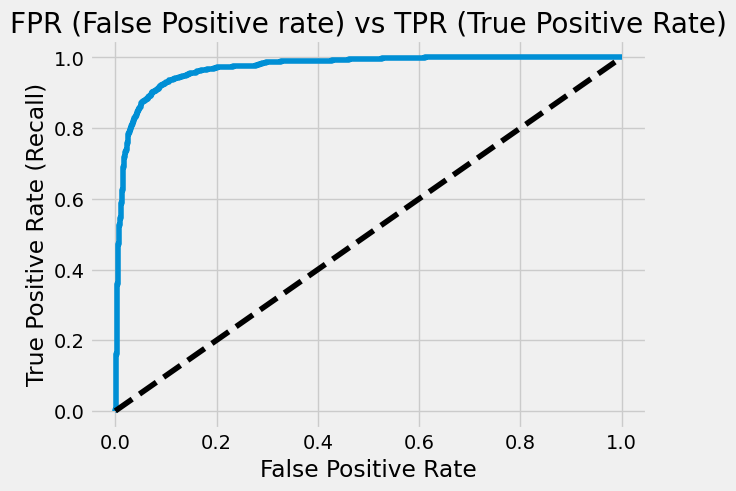

In [16]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [17]:
predictions = model.predict(X_test)

41/41 [==============================] - 68s 2s/step


**Set thresholds for our model, we want the results to be precise while not sacrificing too much recall**

In [18]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [19]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9220679012345679
Precision on testing set: 0.9293785310734464
Recall on testing set: 0.8123456790123457


**Plotting the confusion matrix.**

[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

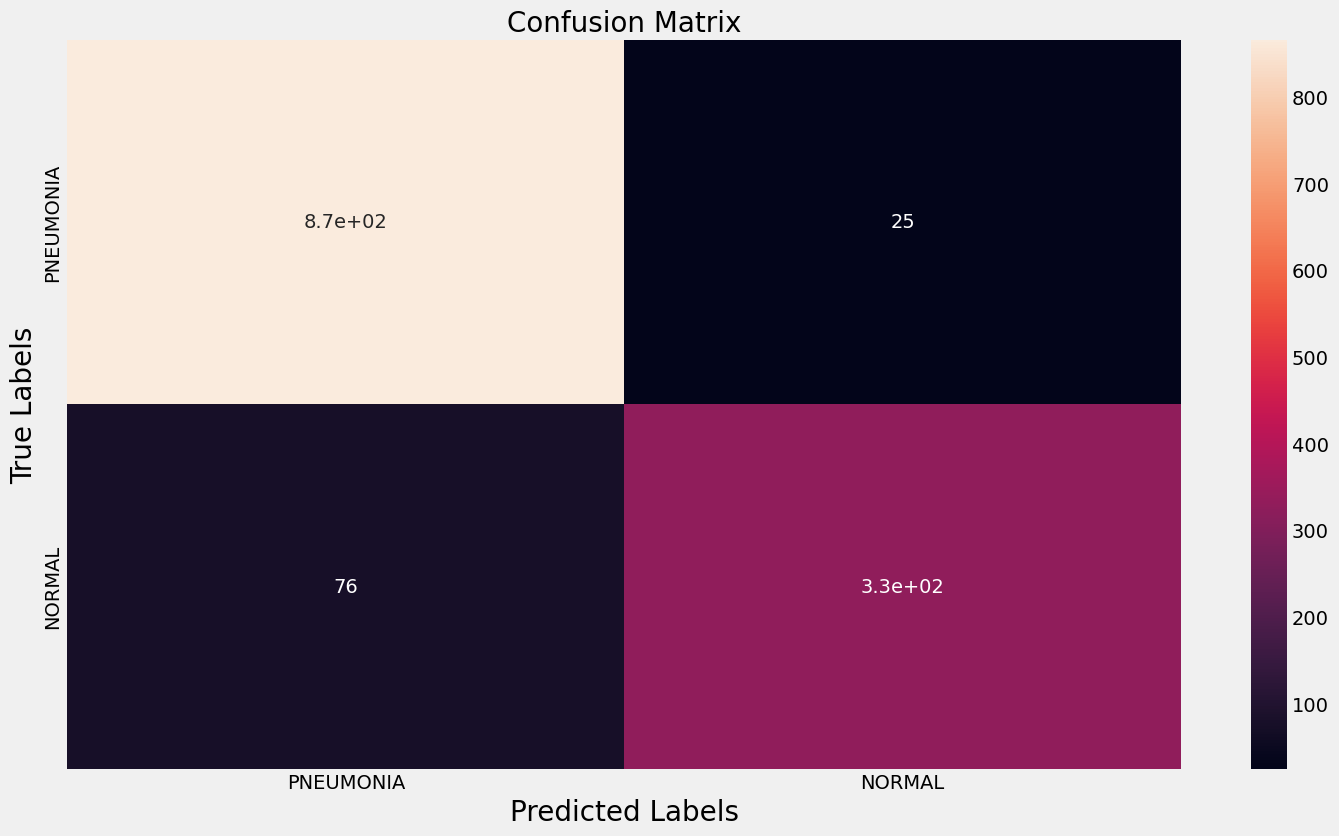

In [20]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

**View some results from a sample of 25 images**

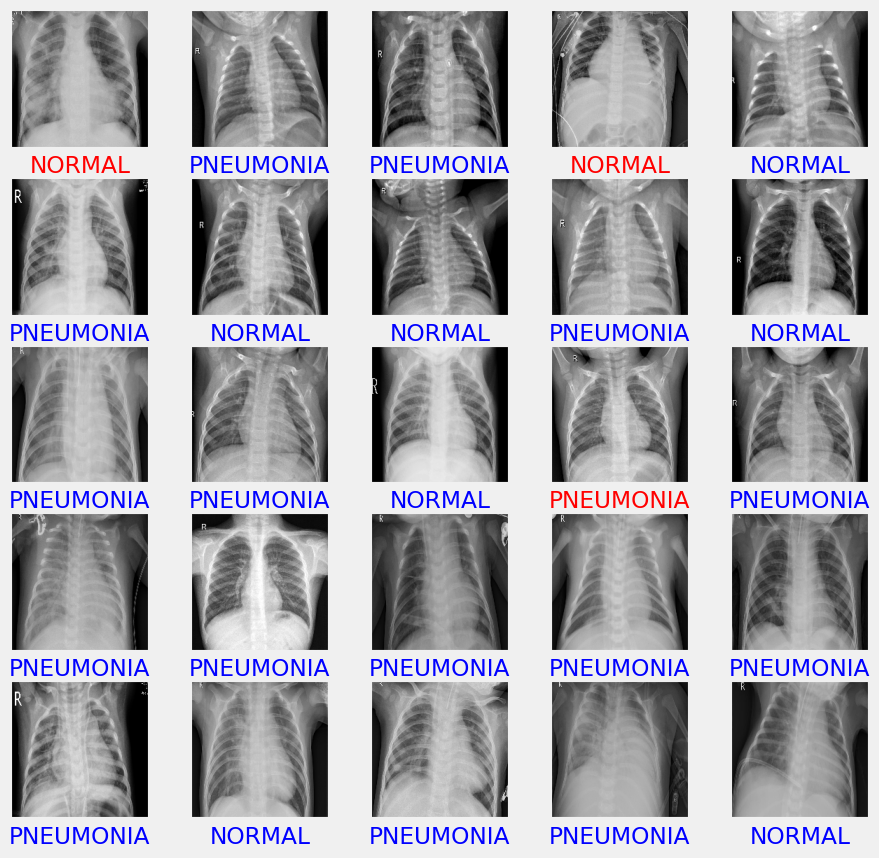

In [21]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

**Download the model**

In [22]:
 model.save('pneumonia_detection_ai_version_3.h5')